In [1]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
env_path = Path(project_root) / ".env"
if env_path.exists():
    load_dotenv(dotenv_path=env_path)
else:
    load_dotenv()

DATA_DIR = Path().resolve().parent / "data"

tex_report_dir = Path().resolve().parent / "tex_report" / "tables"
tex_figures_dir = Path(project_root) / "tex_report" / "figures"



if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math

from linearmodels.panel import PanelOLS
from scipy.stats.mstats import winsorize
from copy import deepcopy

from fredapi import Fred
from stargazer.stargazer import Stargazer

# 1. Data Processing

In [3]:
# Some utils for data processing
def qdate_to_quarter(qdate_series):
    return (
        pd.PeriodIndex(qdate_series, freq='Q')
        .to_timestamp(how = 'end')
    )


def get_stats(res):
    return pd.Series({
        "coef": res.params['dFF_x_Bank_HHI'],
        "std_err": res.std_errors['dFF_x_Bank_HHI'],
        "t": res.tstats['dFF_x_Bank_HHI'],
        "pval": res.pvalues['dFF_x_Bank_HHI']
    }, name = 'dFF_x_Bank_HHI')


## (a) Read data 

In [4]:
pdf_data = pd.read_stata(
    DATA_DIR / "callreports_1976_2020_WRDS.dta"/ "callreports_1976_2020_WRDS.dta",
    # preserve_dtypes = False
    convert_dates = True,
    preserve_dtypes = False
)
pdf_data = pdf_data.dropna(subset=['cert', 'dateq'])
pdf_data['cert'] = pdf_data['cert'].astype('int64')
pdf_data['dateq'] = qdate_to_quarter(pdf_data['dateq'])
pdf_data['date'] = pd.to_datetime(pdf_data['date'], format='ISO8601')
# pdf_data['dateq'] = qdate_to_date(pdf_data)
# pdf_data['dateq'] = pd.to_datetime(pdf_data['dateq'], format='ISO8601')
# pdf_data['date'] = pd.to_datetime(pdf_data['date'], format='ISO8601')

In [5]:
pdf_data.head(1)

,rssdid,chartertype,cert,bhcid,date,name,assets,reloans,cash,persloans,...,intincnet,nonintexp,nonintinc,operinc,salaries,domdepservicecharges,tradingrevenue,intincreloans1to4fam,intexptimedeple250k,intexptimedepge250k
0,28.0,200.0,26606,0.0,1986-03-31,FIRST ATLANTIC BK,2779.0,0.0,1395.0,23.0,...,21.0,52.0,0.0,22.0,26.0,0.0,NaN,NaN,NaN,NaN


## (b). Merge with the Bank Herfindahl

We remove banks with duplicates

In [6]:
# pdf_herf = pd.read_csv(
#     DATA_DIR / "l1_herfdepcty.csv"
# )
# pdf_herf = pdf_herf.dropna()
# pdf_herf['cert'] = pdf_herf['cert'].astype('int64')
# pdf_herf['dateq'] = qdate_to_quarter(pdf_herf['dateq'])

In [7]:
pdf_herf = pd.read_stata(
    DATA_DIR / "l1_herfdepcty.dta",
    convert_dates= True,
    preserve_dtypes= False
)
pdf_herf = pdf_herf.dropna()
pdf_herf['cert'] = pdf_herf['cert'].astype('int64')
pdf_herf['dateq'] = qdate_to_quarter(pdf_herf['dateq'])


In [8]:
pdf_merged = pdf_data.merge(
    pdf_herf,
    on=["cert", "dateq"],
    how="inner",
    suffixes=("", "_herf")
)
pdf_merged.sort_values(['cert','dateq'], inplace=True)
temp_duplicate_certs = (pdf_merged[['cert','dateq', 'date']].groupby(['date', 'cert'])['date'].count() >1)
duplicate_certs = temp_duplicate_certs[temp_duplicate_certs].index.get_level_values('cert').drop_duplicates()
pdf_merged = pdf_merged[~pdf_merged['cert'].isin(duplicate_certs)]

In [9]:
duplicate_certs

Index([5214, 58672], dtype='int64', name='cert')

## (c) Download Fed Funds rate from FRED and merge

We follow the paper's methodology as follows:
* Query the Fed Funds Target rate, which is published until December 2008, and upper and lower target bounds that are published after December 2008.
* From December 2008, I take the average of upper and lower bounds and merge it with the fed funds target rate. 
* The monthly observations are aggregated to quarterly values by taking the average value of the target rate each quarter. 
* Construct the change in fed funds rate $\Delta FF_t = FF_{t+1} - FF_{t}$ where $FF_t$ is aggregated to quarterly frequency from monthly observations by averaging the observations.


In [10]:
# Fetch FRED data
fred = Fred(api_key = os.getenv("API_KEY_FRED"))

target = fred.get_series("DFEDTAR")
lower  = fred.get_series("DFEDTARL")
upper  = fred.get_series("DFEDTARU")

pdf_ffs = pd.concat([target, lower, upper], axis=1)
pdf_ffs.columns = ['fedfunds_target', 'fedfunds_lower', 'fedfunds_upper']
pdf_ffs['fedfunds_new'] = pdf_ffs[[ 'fedfunds_lower', 'fedfunds_upper']].mean(axis=1)
pdf_ffs['fedfunds'] = pdf_ffs['fedfunds_target'].combine_first(pdf_ffs['fedfunds_new'])

pdf_ffs.index.name = "date"
pdf_ffs = pdf_ffs.reset_index()
pdf_ffs['date'] = pd.to_datetime(pdf_ffs['date'], format='YYYY-MM-DD')
pdf_ffs['dateq'] = qdate_to_quarter(pdf_ffs['date'])


In [11]:
# Filter to quarterly frequency 
pdf_ffsq = (
    pdf_ffs.sort_values('date')
    .groupby('dateq', as_index=False)['fedfunds']
    .mean()
)
pdf_ffsq['fedfunds'] = pdf_ffsq['fedfunds'].div(100)
pdf_ffsq['d_fedfunds'] = pdf_ffsq['fedfunds'].diff().shift(-1) # dFF_t = FF_{t+1} - FF_t


In [12]:
pdf_merged = pdf_merged.merge(
    pdf_ffsq,
    on=["dateq"],
    how="inner"
)

## (d) Construct Table 8 variables



### Apply filters
* Remove one outlier 1996-03-31 cert 33260 that has deposits 15, dep interest 3403.0 (huge dep rate)
* Remove banks with non-complete observation history. Majority of banks have complete histories, but there are 33 for which the histories are incomplete. I remove these as potential errors in data. 
* Only keep commercial banks (chartertype 200), as in the paper
* Ignore observations with large asset changes, over 100%, when calculating the log differences. This is done because large changes happen for example due to mergers.

In [13]:
# A large outlier with huge jump in  deposit spread
pdf_merged = pdf_merged[
    ~((pdf_merged['dateq'] == pd.to_datetime("1996-03-31 23:59:59.999999999")) 
    &(pdf_merged['cert'] == 33260))]

# incomplete histories
dateq_diff = pdf_merged['dateq'].drop_duplicates().diff().max()
history_flag = (
    pdf_merged
    .groupby('cert')['dateq']
    .transform(
        lambda x: (x.sort_values().diff() > dateq_diff).any()
        )
    )
pdf_merged['flag_incomplete_hist'] = history_flag
pdf_merged = pdf_merged[~pdf_merged['flag_incomplete_hist']]

# commercial banks
pdf_merged = pdf_merged[pdf_merged['chartertype'] == 200]

# flag large asset changes
pdf_merged['flag_large_asset_change'] = np.abs(pdf_merged.groupby('cert')['assets'].pct_change()) > 1
pdf_merged['asset_change_groups'] = pdf_merged.groupby(['cert'])['flag_large_asset_change'].transform(lambda x: x.cumsum())



### Variable construction 
* All $\Delta Y_{it}$ are calculated as $\Delta Y_{it} = Y_{i, t+1} - Y_{i, t}$ to follow the conventions in the paper. 
* Deposit spread, calculated with average deposits, as $DepositInterest_t / Avg Deposit_t$, where $Avg Deposit_t = \frac{1}{2} (Deposit_t + Deposit_{t-1})$. The idea that deposit interest accumulates during the quarter $t$. However, also the deposit amount of deposits changes inside the quarter and if we use $Deposit_t$ or $Deposit_{t-1}$ we are likely to over or underestimate the amount of deposits that accumulated the interest payments.  

In [14]:
# log change in domestic deposits
def groupbed_log_diff(pdf, value_col, group_col = 'cert'):
    return np.log(pdf[value_col] / (pdf.groupby([group_col,'asset_change_groups'])[value_col].shift(1))).shift(-1)

# Panel A dep-vals (bank liabilities)
pdf_merged['d_total_deposits_A'] = groupbed_log_diff(pdf_merged, 'deposits')
pdf_merged['d_savings_deposits_A'] = groupbed_log_diff(pdf_merged, 'totsavdep')
pdf_merged['d_time_deposits_A'] = groupbed_log_diff(pdf_merged, 'timedep')
pdf_merged['wholesale_funding'] = pdf_merged['liabilities'] - pdf_merged['deposits']
pdf_merged['d_wholesale_funding_A'] = groupbed_log_diff(pdf_merged, 'wholesale_funding')
pdf_merged['d_liabilities_A'] = groupbed_log_diff(pdf_merged, 'liabilities')

# Panel B dep-vals (bank assets)
pdf_merged['d_total_assets_B'] = groupbed_log_diff(pdf_merged, 'assets')
pdf_merged['d_cash_B'] = groupbed_log_diff(pdf_merged, 'cash')
pdf_merged['d_securities_B'] = groupbed_log_diff(pdf_merged, 'securities')
pdf_merged['d_total_loans_B'] = groupbed_log_diff(pdf_merged, 'loans')
pdf_merged['d_real_estate_loans_B'] = groupbed_log_diff(pdf_merged, 'reloans')
pdf_merged['d_ciloans_B'] = groupbed_log_diff(pdf_merged, 'ciloans')

c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc

In [15]:
# Deposit spread based on annualized (x 4) domestic deposits and domestic expenses, 
# even thouth the annualization is not needed for regrs
# To calculate deposit rate for time $t$ use average deposits from $t$ and $t-1$, with this the idea is that interest expense is cumulated over the quarter and thus to match the deposits used should not use end of quarter deposits, but avg deposits produce matching values with the paper
pdf_merged['deposits_lag'] = pdf_merged.groupby(['cert'])['deposits'].shift(1)
pdf_merged['avg_deposits'] = (pdf_merged['deposits'] + pdf_merged['deposits_lag']).div(2)
pdf_merged['dep_rate'] = 4 * pdf_merged['intexpdomdep'] / pdf_merged['avg_deposits']
pdf_merged['deposit_spread'] = pdf_merged['fedfunds'] - pdf_merged['dep_rate']
pdf_merged['d_deposit_spread_A'] = pdf_merged.groupby('cert')['deposit_spread'].diff().shift(-1)

In [16]:
d_columns = [col for col in pdf_merged.columns if col.startswith("d_") and col.endswith(("_A", "_B"))]

### Winsorization

As seen in the box plots below, dependent variables tend to have very large outliers. To limit the influense of these I winsozrize the data at 1% level from both left and right tails.

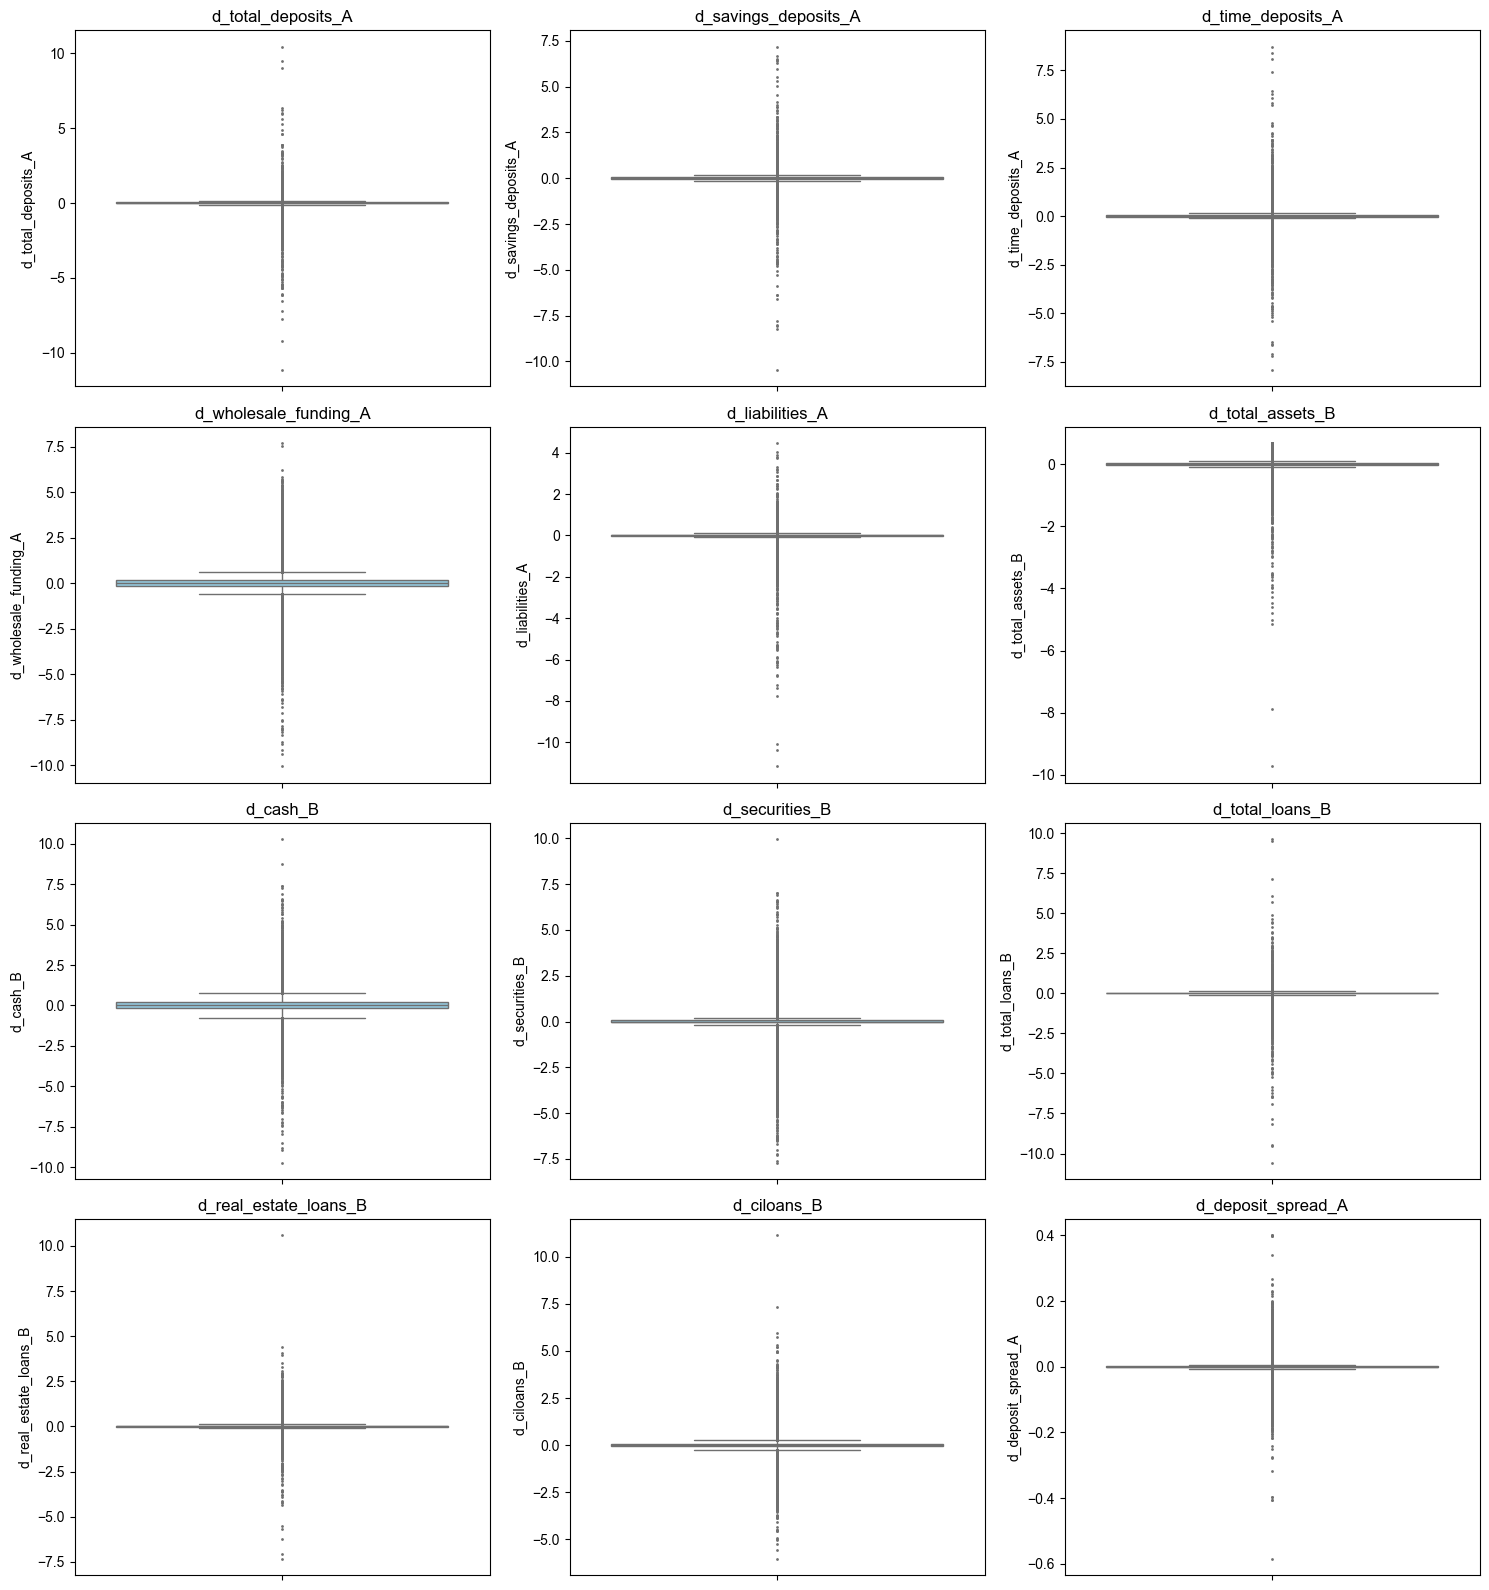

In [17]:
n = len(d_columns)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten() if n > 1 else [axes]

sns.set_style("whitegrid")
for idx, col in enumerate(d_columns):
    ax = axes[idx]
    sns.boxplot(y=pdf_merged[col].dropna(), ax=ax, color="skyblue", fliersize=1)
    ax.set_title(col)

for ax in axes[len(d_columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [18]:
d_columns = [col for col in pdf_merged.columns if col.startswith("d_") and col.endswith(("_A", "_B"))]
for col in d_columns:
    pdf_merged[f"{col}"] = winsorize(pdf_merged[col], limits=[0.01, 0.01])

# 2. Fit Regression Models

In [19]:
pdf_regr = deepcopy(pdf_merged)
pdf_regr['bank_hhi'] = pdf_regr['l1_herfdepcty']
pdf_regr['dFF_x_Bank_HHI'] = pdf_regr['d_fedfunds'] * pdf_regr['bank_hhi']
pdf_regr.set_index(['cert', 'dateq'], inplace=True)

In the paper authors use a model such as 
$$
Y_{i,t} = a_i + \tilde a_i \mathbb{1}_{(t \geq 2009 )} + \delta_t + \beta_1 HHI_{i, t-1} + \beta_2 (HHI_{i, t-1} \Delta FF_t) + \epsilon_{i,t}
$$

Python implementation only supports two different fixed effects for every panelOLS (i.e. It only does at most two orthogonal projections at each call). To fix this issue, we model the interaction

$$
a_i + \tilde a_i \mathbb{1}_{(t \geq 2009 )}
$$
via two firm specific intercepts (can be passed as "other_fixed_effects") as:
$$
\gamma_{i0} := \alpha_i \text{ (for pre 2009), and } \gamma_{i1} := \alpha_i + \tilde \alpha_i \text{ (for post 2009).}
$$

This produces an Python PanelOLS implementation that is equivalent with the one the authors use in the paper

$$
Y_{i,t} = \gamma_{ic} + \delta_t + \beta_1 HHI_{i, t-1} + \beta_2 (HHI_{i, t-1} \Delta FF_t) + \epsilon_{i,t}.
$$

NB: equivalence of the two models is actually geometrically clear from the FWL theore, because both specifications define same (first projection) subspace, then the residual captured by the second step (i.e. that is modeled in $\beta$ is the same).

In [20]:
# Fixed effects related, mentioned in the footnote
pdf_regr["post_2008"] = (pdf_regr.index.get_level_values("dateq") >= pd.to_datetime("2009-01-01")).astype(int)
pdf_regr["fe_bank_post2008"] = pdf_regr.index.get_level_values("cert").astype(str) + "_" + pdf_regr["post_2008"].astype(str)

## d) Run the regressions

In [21]:
# Dependent variables table A 
all_vars = pdf_regr.columns
depvars_a = pdf_regr.columns[all_vars.str.startswith('d_') & all_vars.str.endswith('_A')].tolist()
depvars_a = [depvars_a[0]] + [depvars_a[-1]] + depvars_a[1:-1] # just reorder to match the paper
depvars_b = pdf_regr.columns[all_vars.str.startswith('d_') & all_vars.str.endswith('_B')].tolist()
depvars = depvars_a + depvars_b
# depvars = [d + "_winsorized" for d in depvars]

In [22]:
def table8_reg(df, depvar, entity_effects = False, time_effects = True, other_effects = ["fe_bank_post2008"], model = False):

    mask = df[depvar].notnull() & np.isfinite(df[depvar])
    df = df.loc[mask]
    y = df[depvar]
    X = df[["dFF_x_Bank_HHI", "bank_hhi"]]
    
    mod = PanelOLS(
        y,
        X,
        entity_effects=entity_effects,        
        time_effects=time_effects,
        other_effects= None if other_effects is None else df[other_effects]
    )


    clusters = pd.Series(
        df.index.get_level_values("cert"), 
        index=df.index, name="cert"
    )

    res = mod.fit(
        cov_type="clustered",
        clusters=clusters
    )

    return res

Run Panel VIII Regression

In [23]:

res_panel8 = {dep_val: table8_reg(pdf_regr, dep_val, model=True) for dep_val in depvars}

In [24]:
for name, res in res_panel8.items():
    print(f"\n=== Regression: {name} ===\n")
    # Try to print the neatly formatted summary
    try:
        print(res.summary)
    except Exception:
        # Fallback to str(res)
        print(res)



=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0603
No. Observations:              570383   R-squared (Within):               0.0009
Date:                Tue, Dec 16 2025   R-squared (Overall):              0.0131
Time:                        19:13:39   Log-likelihood                 6.697e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      47.207
Entities:                       11660   P-value                           0.0000
Avg Obs:                       48.918   Distribution:                F(2,551806)
Min Obs:                       1.0000                                           
Max Obs:                       77.000   F-statistic (robust):       

####  Construct latex tables from the results

In [25]:
def create_regression_table(results_dict, depvars=None, depvars_names=None, confint = False):
    """Create a summary DataFrame from panel regression results."""
    if depvars is None:
        depvars = list(results_dict.keys())
    if depvars_names is not None:
        if len(depvars) != len(depvars_names):
            raise ValueError("Length of depvars and depvars_names must match.")
        name_mapping = dict(zip(depvars, depvars_names)) 
    else:
        name_mapping = {var: var for var in depvars}
    
    rows = []
    for var in depvars:
        res = results_dict[var] 
        rows.append({
            'Dependent Variable': name_mapping[var],
            'Coefficient': res.params['dFF_x_Bank_HHI'],
            'Std. Error': res.std_errors['dFF_x_Bank_HHI'],
            # 't-stat': res.tstats['dFF_x_Bank_HHI'],
            'p-value': res.pvalues['dFF_x_Bank_HHI'],
            'Observations': res.nobs,
            'R-squared': res.rsquared_inclusive
        })
        if confint:
            conf_int = res.conf_int().loc['dFF_x_Bank_HHI']
            rows[-1]['CI Lower'] = conf_int['lower']
            rows[-1]['CI Upper'] = conf_int['upper']
    pdf = pd.DataFrame(rows)
    # pdf = pdf.set_index('Dependent Variable').T
    # col_names = {col: f"\\makecell{{{col.replace('_', ' \\\\')}}}" for col in depvars}
    # pdf = pdf.rename(columns=col_names)
    return pdf

In [26]:
def df_to_latex_table(df=None, caption="Regression Results", label="tab:results", 
                     panel_a_df=None, panel_b_df=None, 
                     panel_a_title="Panel A", panel_b_title="Panel B",
                     save_path=None, pvalue_col=None):
    """
    Convert a pandas DataFrame to a clean LaTeX table, or combine two DataFrames as panels.
    
    Parameters:
    -----------
    df : pd.DataFrame, optional
        Single DataFrame (for backward compatibility)
    caption : str
        Table caption
    label : str
        LaTeX label for referencing
    panel_a_df : pd.DataFrame, optional
        Panel A DataFrame
    panel_b_df : pd.DataFrame, optional  
        Panel B DataFrame
    panel_a_title : str
        Title for Panel A
    panel_b_title : str
        Title for Panel B
    save_path : str or Path, optional
        Path to save the LaTeX table
    pvalue_col : str, optional
        Name of the p-value column (e.g., 'p-value') to add significance stars
    
    Returns:
    --------
    str
        LaTeX table code
    """
    
    def format_number(val):
        """Format numbers to max 6 significant figures and 3 decimals."""
        if pd.isna(val):
            return str(val)
        
        try:
            num = float(val)
            if num == 0:
                return "0.000"
            
            # Check if we need thousand separators (for values >= 100)
            if abs(num) >= 100:
                formatted = f"{num:.6g}"
                if 'e' in formatted.lower():
                    return formatted
                
                if '.' in formatted:
                    integer_part, decimal_part = formatted.split('.')
                    if len(decimal_part) > 3:
                        decimal_part = decimal_part[:3]
                    formatted_with_commas = f"{int(integer_part):,}.{decimal_part}"
                else:
                    formatted_with_commas = f"{int(float(formatted)):,}"
                
                return formatted_with_commas
            else:
                formatted = f"{num:.6g}"
                if 'e' in formatted.lower():
                    return formatted
                
                if '.' in formatted:
                    parts = formatted.split('.')
                    if len(parts[1]) > 3:
                        return f"{num:.3f}"
                
                return formatted
                
        except (ValueError, TypeError):
            return str(val)
    
    def get_significance_stars(p_value):
        """Convert p-value to significance stars."""
        if pd.isna(p_value):
            return ""
        
        try:
            p = float(p_value)
            if p < 0.01:
                return "***"
            elif p < 0.05:
                return "**"
            elif p < 0.10:
                return "*"
            else:
                return ""
        except (ValueError, TypeError):
            return ""
    
    def clean_variable_name(name):
        """Clean variable names for LaTeX display."""
        name = str(name).replace('_', ' ')
        
        if len(name) > 15:
            words = name.split()
            if len(words) > 1:
                mid = len(words) // 2
                line1 = ' '.join(words[:mid])
                line2 = ' '.join(words[mid:])
                return f"\\makecell{{{line1} \\\\ {line2}}}"
        
        return name
    
    def process_dataframe(df_input):
        """Process DataFrame to add stars and drop p-value row if needed."""
        if pvalue_col is None:
            return df_input
        
        # Make a copy to avoid modifying original
        df_processed = df_input.copy()
        
        # Add significance stars to coefficient row
        if pvalue_col in df_processed.index and 'Coefficient' in df_processed.index:
            for col in df_processed.columns:
                try:
                    # Get coefficient and p-value
                    coef_val = df_processed.loc['Coefficient', col]
                    p_val = df_processed.loc[pvalue_col, col]
                    
                    # Add stars to coefficient
                    if isinstance(coef_val, (int, float, np.number)):
                        stars = get_significance_stars(p_val)
                        # Store as string with stars
                        df_processed.loc['Coefficient', col] = f"{format_number(coef_val)}{stars}"
                    
                except (KeyError, IndexError, ValueError):
                    pass  # Skip if any issue
        
        # Drop p-value row
        if pvalue_col in df_processed.index:
            df_processed = df_processed.drop(pvalue_col)
        
        return df_processed
    
    def format_dataframe_rows(df_input, is_first_panel=True):
        """Format rows for a single DataFrame."""
        rows = []
        for idx, row in df_input.iterrows():
            formatted_row = [clean_variable_name(idx)]
            
            for val in row.values:
                if isinstance(val, str):
                    # Already formatted (e.g., coefficient with stars)
                    formatted_row.append(val)
                elif isinstance(val, (int, float, np.number)):
                    formatted_row.append(format_number(val))
                else:
                    formatted_row.append(str(val))
            
            rows.append(' & '.join(formatted_row) + ' \\\\')
        
        return rows
    
    # Handle single DataFrame case (backward compatibility)
    if df is not None:
        df = process_dataframe(df)
        nrows, ncols = df.shape
        col_spec = 'l' + 'c' * ncols
        
        latex = []
        latex.append('\\begin{table}[htbp]')
        latex.append('\\centering')
        latex.append(f'\\caption{{{caption}}}')
        latex.append(f'\\label{{{label}}}')
        latex.append(f'\\begin{{tabular}}{{{col_spec}}}')
        latex.append('\\toprule')
        
        index_name = clean_variable_name(df.index.name) if df.index.name else ""
        headers = [index_name] + [clean_variable_name(col) for col in df.columns]
        latex.append(' & '.join(headers) + ' \\\\')
        latex.append('\\midrule')
        
        latex.extend(format_dataframe_rows(df))
        
        latex.append('\\bottomrule')
        latex.append('\\end{tabular}')
        latex.append('\\end{table}')
        
        latex_output = '\n'.join(latex)
    
    # Handle two-panel case
    elif panel_a_df is not None and panel_b_df is not None:
        # Process both panels
        panel_a_processed = process_dataframe(panel_a_df)
        panel_b_processed = process_dataframe(panel_b_df)
        
        # Use the maximum number of columns for the table structure
        ncols_a = panel_a_processed.shape[1]
        ncols_b = panel_b_processed.shape[1]
        max_cols = max(ncols_a, ncols_b)
        col_spec = 'l' + 'c' * max_cols
        
        latex = []
        latex.append('\\begin{table}[htbp]')
        latex.append('\\centering')
        latex.append(f'\\caption{{{caption}}}')
        latex.append(f'\\label{{{label}}}')
        latex.append(f'\\begin{{tabular}}{{{col_spec}}}')
        latex.append('\\toprule')
        
        # Panel A title and column headers
        index_name_a = clean_variable_name(panel_a_processed.index.name) if panel_a_processed.index.name else ""
        headers_a = [index_name_a] + [clean_variable_name(col) for col in panel_a_processed.columns]
        # Pad with empty columns if Panel A has fewer columns than Panel B
        while len(headers_a) <= max_cols:
            headers_a.append('')
        latex.append(' & '.join(headers_a[:max_cols+1]) + ' \\\\')
        latex.append('\\midrule')
        
        # Panel A title and data
        latex.append(f'{panel_a_title} & ' + ' & '.join([''] * max_cols) + ' \\\\')
        latex.extend(format_dataframe_rows(panel_a_processed, is_first_panel=True))
        
        # Spacing between panels
        latex.append('\\\\')
        
        # Panel B title and column headers (if different from Panel A)
        if not panel_a_processed.columns.equals(panel_b_processed.columns):
            index_name_b = clean_variable_name(panel_b_processed.index.name) if panel_b_processed.index.name else ""
            headers_b = [index_name_b] + [clean_variable_name(col) for col in panel_b_processed.columns]
            # Pad with empty columns if Panel B has fewer columns than Panel A
            while len(headers_b) <= max_cols:
                headers_b.append('')
            latex.append(' & '.join(headers_b[:max_cols+1]) + ' \\\\')
            latex.append('\\midrule')
        
        # Panel B title and data  
        latex.append(f'{panel_b_title} & ' + ' & '.join([''] * max_cols) + ' \\\\')
        latex.extend(format_dataframe_rows(panel_b_processed, is_first_panel=False))
        
        latex.append('\\bottomrule')
        latex.append('\\end{tabular}')
        latex.append('\\end{table}')
        
        latex_output = '\n'.join(latex)
    
    else:
        raise ValueError("Either provide 'df' for single table or both 'panel_a_df' and 'panel_b_df' for panel table")
    
    # Save to file if path is provided
    if save_path is not None:
        from pathlib import Path
        save_path = Path(save_path)
        
        # Create directory if it doesn't exist
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Write to file
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(latex_output)
        
        print(f"LaTeX table saved to: {save_path}")
    
    return latex_output

In [27]:
dep_vars_a_names = [r"$\Delta$ " + " ".join(n.split("_")[1:-1]).title() for n in depvars_a]
dep_vars_b_names = [r"$\Delta$ " + " ".join(n.split("_")[1:-1]).title() for n in depvars_b]
table8_a = create_regression_table(res_panel8, depvars=depvars_a, depvars_names=dep_vars_a_names)
table8_b = create_regression_table(res_panel8, depvars=depvars_b, depvars_names=dep_vars_b_names)

In [28]:

combined_latex = df_to_latex_table(
    panel_a_df=table8_a.set_index('Dependent Variable').T,
    panel_b_df=table8_b.set_index('Dependent Variable').T,
    panel_a_title="Panel A: Liabilities", 
    panel_b_title="Panel B: Assets",
    caption="Effects of Monetary Policy on Bank Liabilities and Assets",
    label="tab:table8",
    save_path=tex_report_dir / "table8_combined.tex",
    pvalue_col='p-value'
)

# print(combined_latex)

LaTeX table saved to: C:\Users\palmunen\PR\git\financial_econometrics_II\tex_report\tables\table8_combined.tex


C:\Users\palmunen\AppData\Local\Temp\ipykernel_8708\1653299626.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.578***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_processed.loc['Coefficient', col] = f"{format_number(coef_val)}{stars}"
C:\Users\palmunen\AppData\Local\Temp\ipykernel_8708\1653299626.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.089***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_processed.loc['Coefficient', col] = f"{format_number(coef_val)}{stars}"
C:\Users\palmunen\AppData\Local\Temp\ipykernel_8708\1653299626.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.046***' has dtype incompatible with float64,

## e) The role of fixed effects 
Iterate through all the combinations, {(firm effects), (time effects), (firm effects * 2008_ind), (firm effects, time effects)}

In [29]:
kwargs_to_iterate = {
    'no' : {'entity_effects': False, 'time_effects': False, 'other_effects': None}, # Just a panel without any fixed effects
    'entity': {'entity_effects': True, 'time_effects': False, 'other_effects': None},
    'time': {'entity_effects': False, 'time_effects': True, 'other_effects': None},
    'entityX2008': {'entity_effects': False, 'time_effects': False, 'other_effects': ["fe_bank_post2008"]},
    'entityXtime': {'entity_effects': True, 'time_effects': True, 'other_effects': None},
    'entityXtimeX2008': {'entity_effects': False, 'time_effects': True, 'other_effects': ["fe_bank_post2008"]}, # the base case with all specified fixed effecs
}

In [30]:
fe_results1 = []
for key, kwargs in kwargs_to_iterate.items():
    res_panel = {dep_val: table8_reg(pdf_regr, dep_val, **kwargs) for dep_val in depvars}
    pdf = create_regression_table(res_panel, depvars=depvars, depvars_names=None, confint=True)
    pdf['fixed_effects'] = key
    fe_results1.append(pdf)
    # fe_results[key] = pd.DataFrame(res_panel)


In [31]:
pdf_fe_results = pd.concat(fe_results1, ignore_index=True)
pdf_fe_results

,Dependent Variable,Coefficient,Std. Error,p-value,Observations,R-squared,CI Lower,CI Upper,fixed_effects
0,d_total_deposits_A,-2.164892,0.095838,0.000000,570383,0.045718,-2.352732,-1.977052,no
1,d_deposit_spread_A,2.205874,0.021854,0.000000,559521,0.199113,2.163041,2.248708,no
2,d_savings_deposits_A,-7.783841,0.153837,0.000000,566495,0.032452,-8.085357,-7.482325,no
3,d_time_deposits_A,1.703327,0.150242,0.000000,567689,0.022233,1.408857,1.997796,no
4,d_wholesale_funding_A,8.706801,0.501623,0.000000,570335,0.002760,7.723636,9.689966,no
...,...,...,...,...,...,...,...,...,...
67,d_cash_B,-2.687216,0.671495,0.000063,570344,0.051390,-4.003326,-1.371106,entityXtimeX2008
68,d_securities_B,-1.098642,0.433765,0.011316,563645,0.060390,-1.948808,-0.248477,entityXtimeX2008
69,d_total_loans_B,-0.778732,0.222390,0.000462,495951,0.183555,-1.214609,-0.342855,entityXtimeX2008
70,d_real_estate_loans_B,-0.938845,0.264658,0.000389,494530,0.150468,-1.457567,-0.420123,entityXtimeX2008


### Fixed Effects Comparison Figure

Display how various combinations of fixed effects affect the results

In [32]:
pdf_fe_checks_coef = pdf_fe_results[['fixed_effects', 'Dependent Variable', 'Coefficient']]
pdf_fe_checks_pval = pdf_fe_results[['fixed_effects', 'Dependent Variable', 'p-value']]
pdf_fe_checks_ci = pdf_fe_results[['fixed_effects', 'Dependent Variable', 'CI Lower', 'CI Upper']]

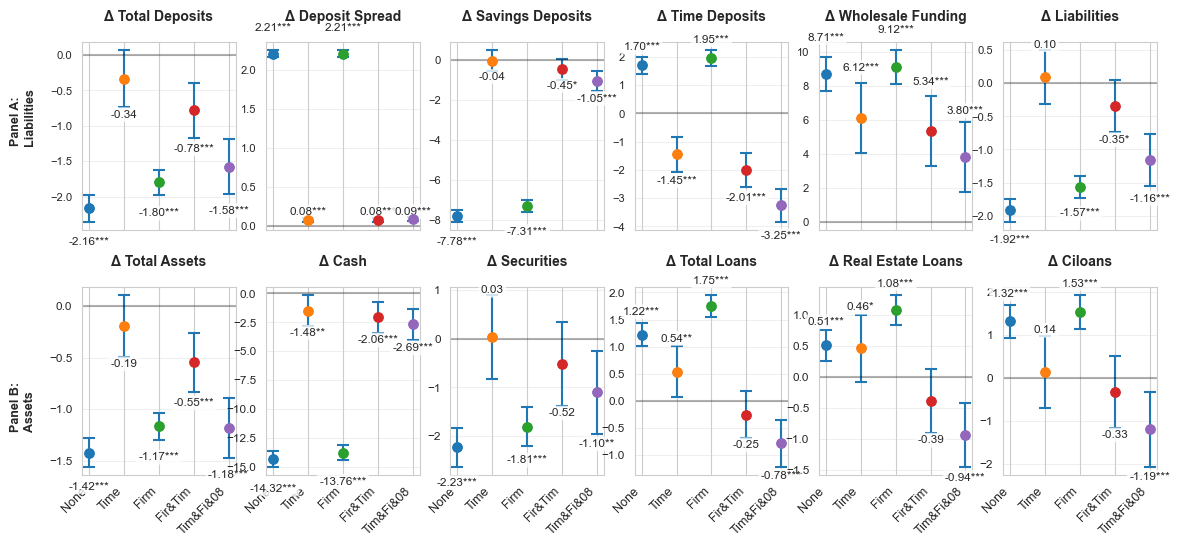

Grid plot: Each subplot shows coefficient values with 95% confidence intervals
Top row: Panel A (Liabilities), Bottom row: Panel B (Assets)
Significance stars shown next to coefficient values: *** p<0.01, ** p<0.05, * p<0.10
Fixed Effects: None, Time, Firm, Firm&08, Fir&Tim, Tim&Fi&08
Saved figure to: c:\Users\palmunen\PR\git\financial_econometrics_II\tex_report\figures\fixed_effects_checks_grid.pdf


In [33]:
# Create fixed effects visualization with grid plots - replicating robustness checks plot
pdf_fe_coef = pdf_fe_checks_coef.pivot(index='Dependent Variable', columns='fixed_effects', values='Coefficient')
pdf_fe_pval = pdf_fe_checks_pval.pivot(index='Dependent Variable', columns='fixed_effects', values='p-value')

# Confidence intervals
pdf_fe_ci_lower = pdf_fe_checks_ci[['fixed_effects', 'Dependent Variable', 'CI Lower']].pivot(
    index='Dependent Variable', columns='fixed_effects', values='CI Lower')
pdf_fe_ci_upper = pdf_fe_checks_ci[['fixed_effects', 'Dependent Variable', 'CI Upper']].pivot(
    index='Dependent Variable', columns='fixed_effects', values='CI Upper')

# Reorder columns and create short names mapping
fe_order = ['no', 'time', 'entity',  # 'entityX2008',  # Remove this to give more space to the plot (not that informative)
            
            
            'entityXtime', 'entityXtimeX2008']
fe_short_names = {
    'no': 'None',
    'time': 'Time', 
    'entity': 'Firm',
    'entityXtime': 'Fir&Tim',
    'entityX2008': 'Firm&08',
    'entityXtimeX2008': 'Tim&Fi&08'
}

# Reorder columns according to desired order
pdf_fe_coef = pdf_fe_coef[fe_order]
pdf_fe_pval = pdf_fe_pval[fe_order]
pdf_fe_ci_lower = pdf_fe_ci_lower[fe_order]
pdf_fe_ci_upper = pdf_fe_ci_upper[fe_order]

# Get Panel A and Panel B variable names
panel_a_vars = depvars_a
panel_b_vars = depvars_b

# Create subplot grid: Panel A on top row, Panel B on bottom row - smaller for LaTeX
n_panel_a = len(panel_a_vars)
n_panel_b = len(panel_b_vars)
n_cols = max(n_panel_a, n_panel_b)

fig, axes = plt.subplots(2, n_cols, figsize=(2.0*n_cols, 5.8))
if n_cols == 1:
    axes = axes.reshape(2, 1)

# Color palette for fixed effects specifications
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Function to get significance stars
def get_stars(p_val):
    if pd.isna(p_val):
        return ""
    if p_val < 0.01:
        return "***"
    elif p_val < 0.05:
        return "**"
    elif p_val < 0.10:
        return "*"
    return ""

# Plot Panel A variables (top row)
for i, var_name in enumerate(panel_a_vars):
    ax = axes[0, i]
    var_coef = pdf_fe_coef.loc[var_name]
    var_pval = pdf_fe_pval.loc[var_name]
    var_ci_lower = pdf_fe_ci_lower.loc[var_name]
    var_ci_upper = pdf_fe_ci_upper.loc[var_name]
    
    # Calculate error bars (distance from coefficient to CI bounds)
    yerr_lower = var_coef - var_ci_lower
    yerr_upper = var_ci_upper - var_coef
    yerr = [yerr_lower.values, yerr_upper.values]
    
    # Scatter plot with error bars
    x_positions = range(len(var_coef))
    ax.errorbar(x_positions, var_coef.values, yerr=yerr, fmt='o', capsize=4, 
                capthick=1.5, elinewidth=1.5, markersize=6)
    
    # Color points by fixed effects specification
    for j, (fe_spec, coef) in enumerate(var_coef.items()):
        ax.scatter(j, coef, color=colors[j], s=45, zorder=5)
    
    # Add coefficient values with stars
    for j, (fe_spec, coef) in enumerate(var_coef.items()):
        pval = var_pval[fe_spec]
        stars = get_stars(pval)
        label_text = f'{coef:.2f}{stars}'
        
        # Position text above/below point based on coefficient sign
        text_y = coef + (var_ci_upper[fe_spec] - coef) + 0.1 * abs(coef) if coef >= 0 else coef - (coef - var_ci_lower[fe_spec]) - 0.1 * abs(coef)
        ax.text(j, text_y, label_text, ha='center', va='bottom' if coef >= 0 else 'top', 
                fontsize=8.5, fontweight='normal',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Format title: remove A/B suffix and replace d with Δ
    title_text = var_name.replace('_', ' ').replace(' A', '').replace(' B', '')
    if title_text.lower().startswith('d '):
        title_text = 'Δ' + title_text[1:]
    ax.set_title(title_text.title(), fontsize=10, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(range(len(var_coef)))
    ax.set_xticklabels([], fontsize=9)  # Remove x-axis labels from top row
    ax.tick_params(axis='y', labelsize=8)

# Plot Panel B variables (bottom row)  
for i, var_name in enumerate(panel_b_vars):
    ax = axes[1, i]
    var_coef = pdf_fe_coef.loc[var_name]
    var_pval = pdf_fe_pval.loc[var_name]
    var_ci_lower = pdf_fe_ci_lower.loc[var_name]
    var_ci_upper = pdf_fe_ci_upper.loc[var_name]
    
    # Calculate error bars (distance from coefficient to CI bounds)
    yerr_lower = var_coef - var_ci_lower
    yerr_upper = var_ci_upper - var_coef
    yerr = [yerr_lower.values, yerr_upper.values]
    
    # Scatter plot with error bars
    x_positions = range(len(var_coef))
    ax.errorbar(x_positions, var_coef.values, yerr=yerr, fmt='o', capsize=4, 
                capthick=1.5, elinewidth=1.5, markersize=6)
    
    # Color points by fixed effects specification
    for j, (fe_spec, coef) in enumerate(var_coef.items()):
        ax.scatter(j, coef, color=colors[j], s=45, zorder=5)
    
    # Add coefficient values with stars
    for j, (fe_spec, coef) in enumerate(var_coef.items()):
        pval = var_pval[fe_spec]
        stars = get_stars(pval)
        label_text = f'{coef:.2f}{stars}'
        
        # Position text above/below point based on coefficient sign
        text_y = coef + (var_ci_upper[fe_spec] - coef) + 0.1 * abs(coef) if coef >= 0 else coef - (coef - var_ci_lower[fe_spec]) - 0.1 * abs(coef)
        ax.text(j, text_y, label_text, ha='center', va='bottom' if coef >= 0 else 'top', 
                fontsize=8.5, fontweight='normal',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8))
    
    # Create x-axis labels without significance stars (just short names)
    x_labels = []
    for fe_spec in var_coef.index:
        short_name = fe_short_names[fe_spec]
        x_labels.append(short_name)
    
    # Format title: remove A/B suffix and replace d with Δ
    title_text = var_name.replace('_', ' ').replace(' A', '').replace(' B', '')
    if title_text.lower().startswith('d '):
        title_text = 'Δ' + title_text[1:]
    ax.set_title(title_text.title(), fontsize=10, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(range(len(var_coef)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
    ax.tick_params(axis='y', labelsize=8.5)

# Remove unused subplots
for i in range(n_panel_a, n_cols):
    fig.delaxes(axes[0, i])
for i in range(n_panel_b, n_cols):
    fig.delaxes(axes[1, i])

# Add panel labels
fig.text(0.02, 0.75, 'Panel A:\nLiabilities', fontsize=9, fontweight='bold', rotation=90, va='center')
fig.text(0.02, 0.25, 'Panel B:\nAssets', fontsize=9, fontweight='bold', rotation=90, va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.88, left=0.08, hspace=0.3, wspace=0.2)
plt.show()

print("Grid plot: Each subplot shows coefficient values with 95% confidence intervals")
print("Top row: Panel A (Liabilities), Bottom row: Panel B (Assets)")  
print("Significance stars shown next to coefficient values: *** p<0.01, ** p<0.05, * p<0.10")
print("Fixed Effects: None, Time, Firm, Firm&08, Fir&Tim, Tim&Fi&08")

# Save figure
pdf_path = tex_figures_dir / "fixed_effects_checks_grid.pdf"
fig.savefig(pdf_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to: {pdf_path}")

In [34]:
# Summary tables of the fixed effects results
fe_results = {}
for key, kwargs in kwargs_to_iterate.items():
    res_panel = {dep_val: get_stats(table8_reg(pdf_regr, dep_val, **kwargs)) for dep_val in depvars}
    fe_results[key] = pd.DataFrame(res_panel)


fe_results_summary = []
for depvar in fe_results['entity'].columns:
    print(f"\n{'='*80}")
    print(f"Dependent Variable: {depvar}")
    print(f"{'='*80}\n")
    
    results_for_depvar = pd.DataFrame({
        fe_spec: fe_results[fe_spec][depvar] 
        for fe_spec in fe_results.keys()
    })
    results_for_depvar.index.name = 'val'
    results_for_depvar['Coefficient'] = depvar
    results_for_depvar = results_for_depvar.reset_index()
    fe_results_summary.append(results_for_depvar)
    print(results_for_depvar.to_string())

pdf_fe_effect = pd.concat(fe_results_summary, axis=0)


Dependent Variable: d_total_deposits_A

       val         no     entity      time  entityX2008  entityXtime  entityXtimeX2008         Coefficient
0     coef  -2.164892  -1.799245 -0.335124    -1.140313    -0.781110     -1.578404e+00  d_total_deposits_A
1  std_err   0.095838   0.092796  0.205666     0.092428     0.199750      1.987805e-01  d_total_deposits_A
2        t -22.589060 -19.389320 -1.629455   -12.337333    -3.910437     -7.940438e+00  d_total_deposits_A
3     pval   0.000000   0.000000  0.103217     0.000000     0.000092      1.998401e-15  d_total_deposits_A

Dependent Variable: d_deposit_spread_A

       val          no      entity          time  entityX2008   entityXtime  entityXtimeX2008         Coefficient
0     coef    2.205874    2.205695  8.305289e-02     2.183321  8.385113e-02      8.876533e-02  d_deposit_spread_A
1  std_err    0.021854    0.021974  1.289904e-02     0.022202  1.303339e-02      1.321038e-02  d_deposit_spread_A
2        t  100.936359  100.375415  6.438

## f) Robustness Checks

### Results upto and including 2007Q4

In [35]:
pdf_regr2008 =pdf_regr.loc[
    pdf_regr.index.get_level_values('dateq') < pd.to_datetime('2008-01-01')
] 
res_panel_robust2008 = {dep_val: table8_reg(
        pdf_regr2008, 
        dep_val
    )
    for dep_val in depvars
}

In [36]:
for name, res in res_panel_robust2008.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0244
No. Observations:              423340   R-squared (Within):               0.0008
Date:                Tue, Dec 16 2025   R-squared (Overall):              0.0099
Time:                        19:20:21   Log-likelihood                 5.034e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      26.104
Entities:                       11398   P-value                           0.0000
Avg Obs:                       37.142   Distribution:                F(2,411887)
Min Obs:                       1.0000                                           
Max Obs:                       54.000   F-statistic (robust):       

### Analysis with largest 10% of banks. 

Take top 10% of names based on average assets, where the average is taken across banks lifetime. 

In [37]:
# pdf_regr['flag_top_10'] = pdf_regr.groupby('dateq')['assets'].transform(lambda x: x > np.quantile(x, 0.9))
# top_10_cert = pdf_regr[pdf_regr['flag_top_10']].index.get_level_values('cert').drop_duplicates()
pds_average_assets = pdf_regr.groupby(['cert'])['assets'].mean()
top_10_cert = pds_average_assets[pds_average_assets > np.quantile(pds_average_assets, 0.90)].index
pdf_regr_top10 = pdf_regr.loc[
    pdf_regr.index.get_level_values('cert').isin(top_10_cert)
]
res_panel_robust_top10 = {dep_val: table8_reg(
        pdf_regr_top10, dep_val
    )
    for dep_val in depvars
}

In [38]:
for name, res in res_panel_robust_top10.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     3.041e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0824
No. Observations:               50521   R-squared (Within):             -9.2e-05
Date:                Tue, Dec 16 2025   R-squared (Overall):              0.0112
Time:                        19:20:50   Log-likelihood                 3.282e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7413
Entities:                        1159   P-value                           0.4765
Avg Obs:                       43.590   Distribution:                 F(2,48744)
Min Obs:                       1.0000                                           
Max Obs:                       77.000   F-statistic (robust):       

### Analysis with largest 25% of banks

In [39]:
# pdf_regr['flag_top_25'] = pdf_regr.groupby('dateq')['assets'].transform(lambda x: x > np.quantile(x, 0.75))
# top_25_cert = pdf_regr[pdf_regr['flag_top_25']].index.get_level_values('cert').drop_duplicates()

top_25_cert = pds_average_assets[pds_average_assets > np.quantile(pds_average_assets, 0.75)].index
pdf_regr_top25 = pdf_regr.loc[
    pdf_regr.index.get_level_values('cert').isin(top_25_cert)
]
res_panel_robust_top25 = {dep_val: table8_reg(
        pdf_regr_top25, dep_val
    )
    for dep_val in depvars
}

In [40]:
for name, res in res_panel_robust_top25.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.0224
No. Observations:              136412   R-squared (Within):              -0.0004
Date:                Tue, Dec 16 2025   R-squared (Overall):             -0.0043
Time:                        19:20:56   Log-likelihood                 1.255e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.6270
Entities:                        2911   P-value                           0.0013
Avg Obs:                       46.861   Distribution:                F(2,131845)
Min Obs:                       1.0000                                           
Max Obs:                       77.000   F-statistic (robust):       

### Combined robustness check analysis

In [41]:
pdf_baseline = create_regression_table(res_panel8)
pdf_baseline['check'] = 'Baseline'
pdf_panel_8_r2008 = create_regression_table(res_panel_robust2008, confint=True)
pdf_panel_8_r2008['check'] = 'Pre 2008'
pdf_panel_8_rtop10 = create_regression_table(res_panel_robust_top10, confint=True)
pdf_panel_8_rtop10['check'] = 'Top 10'
pdf_panel_8_rtop25 = create_regression_table(res_panel_robust_top25, confint=True)
pdf_panel_8_rtop25['check'] = 'Top 25'

pdf_robust_checks = pd.concat(
    [pdf_baseline, pdf_panel_8_r2008, pdf_panel_8_rtop10, pdf_panel_8_rtop25],
    axis=0  )

In [ ]:
temp = pdf_robust_checks[pdf_robust_checks['check'].isin(['Baseline', 'Top 10'])].sort_values(['Dependent Variable','check'])

,Dependent Variable,Coefficient,Std. Error,p-value,Observations,R-squared,check,CI Lower,CI Upper
7,d_cash_B,-2.687216,0.671495,6.286042e-05,570344,0.051390,Baseline,NaN,NaN
7,d_cash_B,5.487356,4.107191,1.815437e-01,50551,0.063911,Top 10,-2.562790,13.537503
11,d_ciloans_B,-1.188986,0.445629,7.628259e-03,564210,0.062252,Baseline,NaN,NaN
11,d_ciloans_B,3.443150,3.455482,3.190459e-01,48716,0.091770,Top 10,-3.329645,10.215945
1,d_deposit_spread_A,0.088765,0.013210,1.827027e-11,559521,0.328006,Baseline,NaN,NaN
1,d_deposit_spread_A,0.259503,0.093085,5.308937e-03,49642,0.167071,Top 10,0.077054,0.441952
5,d_liabilities_A,-1.158458,0.199645,6.532969e-09,570496,0.161820,Baseline,NaN,NaN
5,d_liabilities_A,1.836650,1.423390,1.969404e-01,50558,0.132384,Top 10,-0.953212,4.626513
10,d_real_estate_loans_B,-0.938845,0.264658,3.891136e-04,494530,0.150468,Baseline,NaN,NaN
10,d_real_estate_loans_B,1.522390,1.671308,3.623545e-01,44549,0.104710,Top 10,-1.753405,4.798185


In [55]:
temp = pdf_robust_checks[pdf_robust_checks['check'].isin(['Baseline', 'Top 10'])].sort_values(['Dependent Variable','check'])
for depvar in depvars:
    temp_dep = temp[temp['Dependent Variable'] == depvar]
    se_base = temp_dep[temp_dep['check'] == 'Baseline']['Std. Error'].values[0]
    se_top10 = temp_dep[temp_dep['check'] == 'Top 10']['Std. Error'].values[0]
    n_base = temp_dep[temp_dep['check'] == 'Baseline']['Observations'].values[0]
    n_top10 = temp_dep[temp_dep['check'] == 'Top 10']['Observations'].values[0]
    print(f"Rescaled standard error diffeerence for depvar {depvar}:")
    print(f"Se Baseline: {se_base}, Se Top 10: {se_top10 * np.sqrt(n_top10 / n_base)}, scale factor: {np.sqrt(n_base / n_top10)}")


Rescaled standard error diffeerence for depvar d_total_deposits_A:
Se Baseline: 0.19878047619000194, Se Top 10: 0.38853784006494707, scale factor: 3.360062203637265
Rescaled standard error diffeerence for depvar d_deposit_spread_A:
Se Baseline: 0.013210384668365363, Se Top 10: 0.027726696271712727, scale factor: 3.357249056592678
Rescaled standard error diffeerence for depvar d_savings_deposits_A:
Se Baseline: 0.26416306621359703, Se Top 10: 0.7002047274375854, scale factor: 3.377222735594235
Rescaled standard error diffeerence for depvar d_time_deposits_A:
Se Baseline: 0.29872768258363147, Se Top 10: 0.5416964387784609, scale factor: 3.3707170176758052
Rescaled standard error diffeerence for depvar d_wholesale_funding_A:
Se Baseline: 1.055054864831316, Se Top 10: 1.056624829710763, scale factor: 3.358757578704622
Rescaled standard error diffeerence for depvar d_liabilities_A:
Se Baseline: 0.19964456873801933, Se Top 10: 0.4237332895493918, scale factor: 3.35916517369832
Rescaled stand

In [57]:
n_base = 567092
n_top = 50000
print(f"Scale factor for standard errors from Baseline to Top 10: {np.sqrt(n_base / n_top)}")

Scale factor for standard errors from Baseline to Top 10: 3.3677648373958653


### Robustness Checks Figure

In [43]:
pdf_robust_checks_coef = pdf_robust_checks[['check', 'Dependent Variable', 'Coefficient']]
pdf_robust_checks_pval = pdf_robust_checks[['check', 'Dependent Variable', 'p-value']]
pdf_robust_checks_ci = pdf_robust_checks[['check', 'Dependent Variable', 'CI Lower', 'CI Upper']]


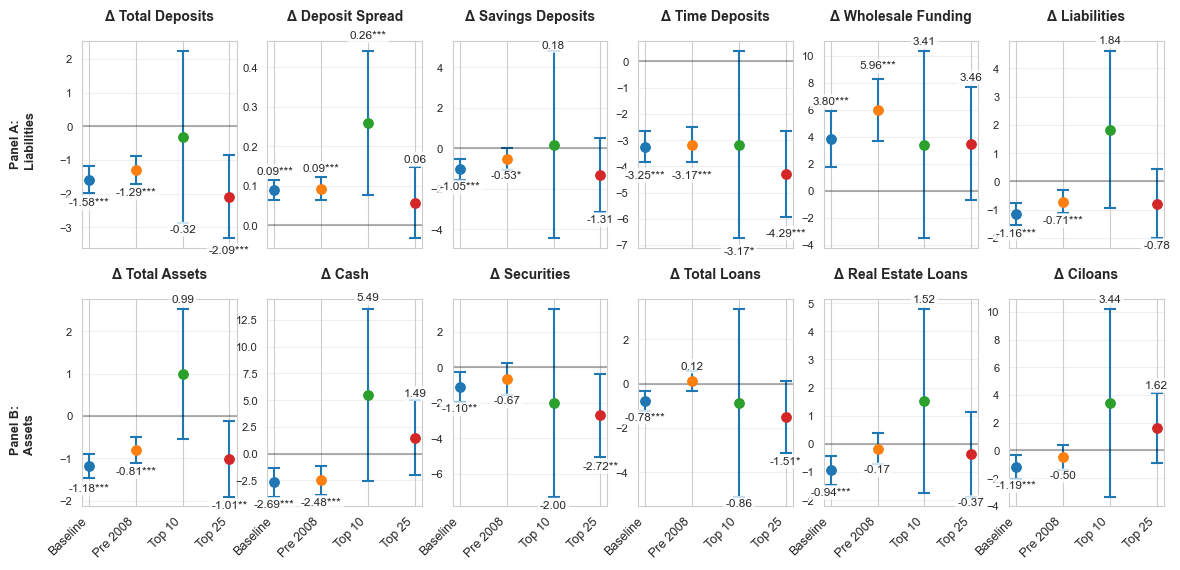

Grid plot: Each subplot shows coefficient values with 95% confidence intervals
Top row: Panel A (Liabilities), Bottom row: Panel B (Assets)
Significance: *** p<0.01, ** p<0.05, * p<0.10
Robustness checks: Baseline (full sample), Pre 2008 (pre-crisis), Top 10/25 (largest banks)
Saved figure to: c:\Users\palmunen\PR\git\financial_econometrics_II\tex_report\figures\robustness_checks_grid.pdf


In [44]:
# Create robustness checks visualization with grid plots
pdf_robust_coef = pdf_robust_checks_coef.pivot(index='Dependent Variable', columns='check', values='Coefficient')
pdf_robust_pval = pdf_robust_checks_pval.pivot(index='Dependent Variable', columns='check', values='p-value')
pdf_robust_nobs = pdf_robust_checks[['check', 'Dependent Variable', 'Observations']].pivot(
    index='Dependent Variable', columns='check', values='Observations')

# Confidence intervals - need to handle missing CI data for baseline
pdf_robust_ci_lower = pdf_robust_checks[['check', 'Dependent Variable', 'CI Lower']].pivot(
    index='Dependent Variable', columns='check', values='CI Lower')
pdf_robust_ci_upper = pdf_robust_checks[['check', 'Dependent Variable', 'CI Upper']].pivot(
    index='Dependent Variable', columns='check', values='CI Upper')


pdf_robust_stderr = pdf_robust_checks[['check', 'Dependent Variable', 'Std. Error']].pivot(
    index='Dependent Variable', columns='check', values='Std. Error')

# Fill missing CI values for baseline using 1.96 * std_err
for var_name in pdf_robust_coef.index:
    if pd.isna(pdf_robust_ci_lower.loc[var_name, 'Baseline']):
        coef = pdf_robust_coef.loc[var_name, 'Baseline']
        stderr = pdf_robust_stderr.loc[var_name, 'Baseline']
        pdf_robust_ci_lower.loc[var_name, 'Baseline'] = coef - 1.96 * stderr
        pdf_robust_ci_upper.loc[var_name, 'Baseline'] = coef + 1.96 * stderr

# Get Panel A and Panel B variable names
panel_a_vars = depvars_a
panel_b_vars = depvars_b

# Create subplot grid: Panel A on top row, Panel B on bottom row - smaller for LaTeX
n_panel_a = len(panel_a_vars)
n_panel_b = len(panel_b_vars)
n_cols = max(n_panel_a, n_panel_b)

fig, axes = plt.subplots(2, n_cols, figsize=(2.0*n_cols, 5.8))
if n_cols == 1:
    axes = axes.reshape(2, 1)

# Color palette for robustness checks
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Function to get significance stars
def get_stars(p_val):
    if pd.isna(p_val):
        return ""
    if p_val < 0.01:
        return "***"
    elif p_val < 0.05:
        return "**"
    elif p_val < 0.10:
        return "*"
    return ""

# Plot Panel A variables (top row)
for i, var_name in enumerate(panel_a_vars):
    ax = axes[0, i]
    var_coef = pdf_robust_coef.loc[var_name]
    var_pval = pdf_robust_pval.loc[var_name]
    var_ci_lower = pdf_robust_ci_lower.loc[var_name]
    var_ci_upper = pdf_robust_ci_upper.loc[var_name]
    
    # Calculate error bars (distance from coefficient to CI bounds)
    yerr_lower = var_coef - var_ci_lower
    yerr_upper = var_ci_upper - var_coef
    yerr = [yerr_lower.values, yerr_upper.values]
    
    # Scatter plot with error bars
    x_positions = range(len(var_coef))
    ax.errorbar(x_positions, var_coef.values, yerr=yerr, fmt='o', capsize=4, 
                capthick=1.5, elinewidth=1.5, markersize=6)
    
    # Color points by robustness check
    for j, (check, coef) in enumerate(var_coef.items()):
        ax.scatter(j, coef, color=colors[j], s=45, zorder=5)
    
    # Add coefficient values (without stars)
    for j, (check, coef) in enumerate(var_coef.items()):
        # label_text = f'{coef:.3f}'
        
        # # Position text above/below point based on coefficient sign
        # text_y = coef + (var_ci_upper[check] - coef) + 0.1 * abs(coef) if coef >= 0 else coef - (coef - var_ci_lower[check]) - 0.1 * abs(coef)
        # ax.text(j, text_y, label_text, ha='center', va='bottom' if coef >= 0 else 'top', 
        #         fontsize=8, fontweight='normal',
        #         )

        pval = var_pval[check]
        stars = get_stars(pval)
        label_text = f'{coef:.2f}{stars}'
        
        # Position text above/below point based on coefficient sign
        text_y = coef + (var_ci_upper[check] - coef) + 0.1 * abs(coef) if coef >= 0 else coef - (coef - var_ci_lower[check]) - 0.1 * abs(coef)
        ax.text(j, text_y, label_text, ha='center', va='bottom' if coef >= 0 else 'top', 
                fontsize=8.5, fontweight='normal',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8))



    # Format title: remove A/B suffix and replace d with Δ
    title_text = var_name.replace('_', ' ').replace(' A', '').replace(' B', '')
    if title_text.lower().startswith('d '):
        title_text = 'Δ' + title_text[1:]
    ax.set_title(title_text.title(), fontsize=10, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(range(len(var_coef)))
    ax.set_xticklabels([], fontsize=9)  # Remove x-axis labels from top row
    ax.tick_params(axis='y', labelsize=8)

# Plot Panel B variables (bottom row)  
for i, var_name in enumerate(panel_b_vars):
    ax = axes[1, i]
    var_coef = pdf_robust_coef.loc[var_name]
    var_pval = pdf_robust_pval.loc[var_name]
    var_ci_lower = pdf_robust_ci_lower.loc[var_name]
    var_ci_upper = pdf_robust_ci_upper.loc[var_name]
    
    # Calculate error bars (distance from coefficient to CI bounds)
    yerr_lower = var_coef - var_ci_lower
    yerr_upper = var_ci_upper - var_coef
    yerr = [yerr_lower.values, yerr_upper.values]
    
    # Scatter plot with error bars
    x_positions = range(len(var_coef))
    ax.errorbar(x_positions, var_coef.values, yerr=yerr, fmt='o', capsize=4, 
                capthick=1.5, elinewidth=1.5, markersize=6)
    
    # Color points by robustness check
    for j, (check, coef) in enumerate(var_coef.items()):
        ax.scatter(j, coef, color=colors[j], s=45, zorder=5)
    
    # Add coefficient values (without stars)
    for j, (check, coef) in enumerate(var_coef.items()):
        # label_text = f'{coef:.3f}'
        
        # # Position text above/below point based on coefficient sign
        # text_y = coef + (var_ci_upper[check] - coef) + 0.1 * abs(coef) if coef >= 0 else coef - (coef - var_ci_lower[check]) - 0.1 * abs(coef)
        # ax.text(j, text_y, label_text, ha='center', va='bottom' if coef >= 0 else 'top', 
        #         fontsize=8, fontweight='normal')
        pval = var_pval[check]
        stars = get_stars(pval)
        label_text = f'{coef:.2f}{stars}'
        
        # Position text above/below point based on coefficient sign
        text_y = coef + (var_ci_upper[check] - coef) + 0.1 * abs(coef) if coef >= 0 else coef - (coef - var_ci_lower[check]) - 0.1 * abs(coef)
        ax.text(j, text_y, label_text, ha='center', va='bottom' if coef >= 0 else 'top', 
                fontsize=8.5, fontweight='normal',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8))



    # Create x-axis labels with significance stars
    x_labels = []
    for check in var_coef.index:
        pval = var_pval[check]
        # stars = get_stars(pval)
        x_labels.append(f'{check}')
    
    # Format title: remove A/B suffix and replace d with Δ
    title_text = var_name.replace('_', ' ').replace(' A', '').replace(' B', '')
    if title_text.lower().startswith('d '):
        title_text = 'Δ' + title_text[1:]
    ax.set_title(title_text.title(), fontsize=10, fontweight='bold', pad=15)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(range(len(var_coef)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
    ax.tick_params(axis='y', labelsize=8)

# Remove unused subplots
for i in range(n_panel_a, n_cols):
    fig.delaxes(axes[0, i])
for i in range(n_panel_b, n_cols):
    fig.delaxes(axes[1, i])

# Add overall title
# fig.suptitle('Robustness Checks: Coefficients with 95% Confidence Intervals', fontsize=11, fontweight='bold', y=0.96)

# Add panel labels
fig.text(0.02, 0.75, 'Panel A:\nLiabilities', fontsize=9, fontweight='bold', rotation=90, va='center')
fig.text(0.02, 0.25, 'Panel B:\nAssets', fontsize=9, fontweight='bold', rotation=90, va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.08, hspace=0.25, wspace=0.2)
plt.show()

print("Grid plot: Each subplot shows coefficient values with 95% confidence intervals")
print("Top row: Panel A (Liabilities), Bottom row: Panel B (Assets)")  
print("Significance: *** p<0.01, ** p<0.05, * p<0.10")
print("Robustness checks: Baseline (full sample), Pre 2008 (pre-crisis), Top 10/25 (largest banks)")

# Save figure
pdf_path = tex_figures_dir / "robustness_checks_grid.pdf"
fig.savefig(pdf_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to: {pdf_path}")

In [45]:
pdf_robust_checks[['check', 'Dependent Variable', 'Observations']].groupby('check')['Observations'].median()

check
Baseline    567092.0
Pre 2008    421667.0
Top 10       49994.5
Top 25      135480.0
Name: Observations, dtype: float64

# A. Descriptive stats to see that transformations match with the paper

<Axes: xlabel='dateq'>

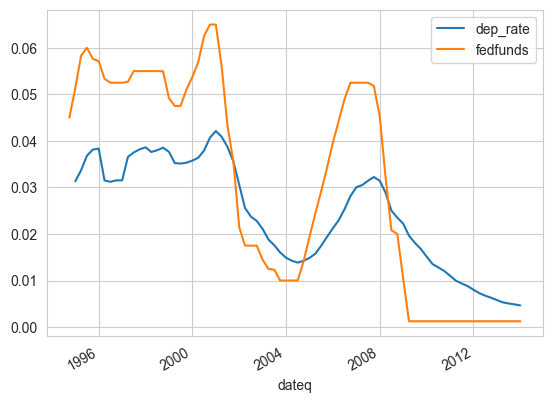

In [46]:
temp_mean = pdf_merged.groupby('dateq')[['dep_rate', 'fedfunds']].mean()
temp_mean.plot()